# Análisis de Rendimiento: Contador Preciso vs. Contador Aproximado (Sloppy)

## 1. Contexto del Experimento (Sistemas Operativos)

Este notebook analiza los resultados de un experimento de concurrencia. El objetivo es comparar dos estrategias para implementar un contador global que es accedido simultáneamente por múltiples hilos.

El escenario de prueba (`benchmark_counters.c`) mide el tiempo total que tardan `N` hilos en incrementar un contador `M` veces cada uno (para este experimento, `M = 10,000,000`).

### El Problema: El Contador Preciso (`precise_counter.c`)

Esta implementación es la más simple e intuitiva. Utiliza un único *mutex* global (`pthread_mutex_t`) para proteger el valor del contador.

**Estrategia:** Cada vez que un hilo desea incrementar el contador (`precise_increment()`), debe:
1. Adquirir el bloqueo (lock).
2. Incrementar el valor.
3. Liberar el bloqueo (unlock).

**Hipótesis (El Problema):** En un sistema multinúcleo, a medida que aumenta el número de hilos (`N`), estos competirán intensamente por adquirir ese **único bloqueo**. Este fenómeno se conoce como **alta contención de bloqueo (lock contention)**.

Se espera que el rendimiento no escale bien. Los hilos pasarán más tiempo esperando a que se libere el bloqueo que realizando trabajo útil, convirtiendo el *mutex* en un cuello de botella.

### La Solución: El Contador Aproximado (`sloppy_counter.c`)

Esta implementación (también conocida como "Sloppy Counter" o "Contador Perezoso") utiliza una estrategia más sofisticada para minimizar la contención del bloqueo.

**Estrategia:** 
* Mantiene un **contador global** (protegido por un *mutex* global, `glock`).
* Mantiene un **contador local** para cada CPU/hilo (en este caso, `NUMCPUS=8`), cada uno protegido por su propio *mutex* local (`llock[i]`).
* Cuando un hilo actualiza el contador (`sloppy_update()`), solo incrementa su contador **local** (adquiriendo solo el bloqueo *local*, que tiene muy baja contención).
* Solo cuando el contador local de un hilo alcanza un **umbral (threshold)** (en este caso, `THRESHOLD=1024`), el hilo:
    1. Adquiere el bloqueo **global**.
    2. Transfiere el valor de su contador local al global.
    3. Resetea su contador local a 0.
    4. Libera el bloqueo **global**.

**Hipótesis (La Ventaja):** La contención en el costoso bloqueo global se reduce drásticamente (en un factor de `THRESHOLD`). Las operaciones locales son rápidas y paralelas. Se espera que esta implementación **escale mucho mejor** con el número de hilos.

## 2. Carga y Preparación de Datos

Importamos las bibliotecas necesarias y cargamos los datos `results.csv` generados por el *benchmark*.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Leer los resultados del CSV
try:
    df = pd.read_csv('results.csv')
except FileNotFoundError:
    print("Error: El archivo 'results.csv' no se encontró.")
    print("Asegúrate de ejecutar primero el benchmark: ./run_benchmark")
    df = pd.DataFrame() # Crear dataframe vacío para evitar errores posteriores

# Separar los datos para cada tipo de contador
if not df.empty:
    precise = df[df['CounterType'] == 'Precise']
    approximate = df[df['CounterType'] == 'Approximate']

    print("Datos cargados exitosamente:")
    display(df.head())

Datos cargados exitosamente:


,Threads,CounterType,Time(s)
0,1,Precise,0.1938
1,1,Approximate,0.2044
2,2,Precise,1.1758
3,2,Approximate,0.4731
4,4,Precise,1.8436


## 3. Visualización y Análisis de Resultados

Generamos la gráfica comparativa y mostramos los datos tabulados para el análisis.

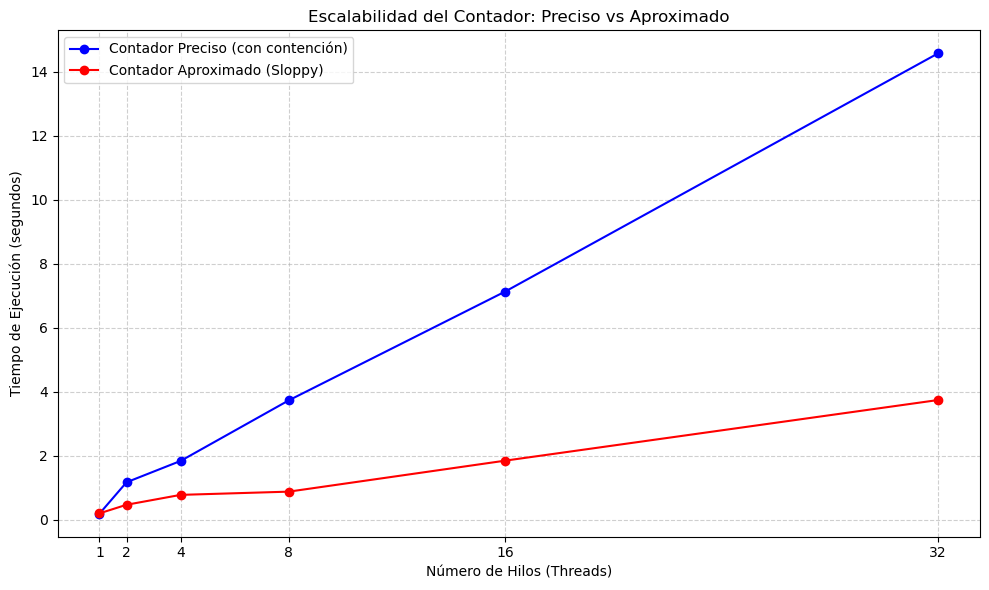


Tabla de Tiempos de Ejecución (segundos):


CounterType,Approximate,Precise
Threads,,
1,0.2044,0.1938
2,0.4731,1.1758
4,0.7824,1.8436
8,0.8834,3.7376
16,1.8521,7.1387
32,3.7469,14.5827


In [9]:
if not df.empty:
    # Configurar el tamaño de la figura
    plt.figure(figsize=(10,6))

    # Graficar ambas líneas
    plt.plot(precise['Threads'], precise['Time(s)'], 'b-o', label='Contador Preciso (con contención)')
    plt.plot(approximate['Threads'], approximate['Time(s)'], 'r-o', label='Contador Aproximado (Sloppy)')

    # Configurar la gráfica
    plt.xlabel('Número de Hilos (Threads)')
    plt.ylabel('Tiempo de Ejecución (segundos)')
    plt.title('Escalabilidad del Contador: Preciso vs Aproximado')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    # Mostrar todos los valores de threads en el eje X
    plt.xticks(df['Threads'].unique())

    # Ajustar márgenes
    plt.tight_layout()

    # Mostrar la gráfica
    plt.show()

    # Mostrar los datos en forma tabular (pivoteada para fácil comparación)
    print("\nTabla de Tiempos de Ejecución (segundos):")
    pivot_table = df.pivot(index='Threads', columns='CounterType', values='Time(s)')
    display(pivot_table)

## 4. Conclusión del Experimento

Como se observa claramente en la gráfica y en la tabla, los resultados validan nuestras hipótesis:

1.  **Contador Preciso (Línea Azul):** El tiempo de ejecución escala de forma lineal (o peor) con el número de hilos. Con 1 hilo tarda `X` segundos, pero con 32 hilos tarda mucho más. Añadir más hilos (trabajadores) hace que el sistema sea **más lento** en general, demostrando el severo impacto de la contención del bloqueo global.

2.  **Contador Aproximado (Línea Roja):** El tiempo de ejecución se mantiene relativamente bajo y escala mucho mejor. Aunque también aumenta el tiempo con más hilos (ya que hay más transferencias al contador global y operaciones), el impacto es drásticamente menor. Con 32 hilos, es significativamente más rápido que el contador preciso.

**Lección Principal:** Para estructuras de datos concurrentes en sistemas multinúcleo, evitar un único punto de contención (como un solo *mutex*) es crucial para la escalabilidad. Técnicas como los contadores "sloppy" ofrecen una solución efectiva, sacrificando la precisión *inmediata* (el contador global no está 100% al día en todo momento) por un rendimiento paralelo masivo.